In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [ ]:
from workspace import nometools as nome

In [ ]:
main_path = Path('..')
preprocessing_path = main_path / 'Data' / 'Preprocessing_LNDR_HNDR'
intersect_path = main_path / 'Data' / 'intersect_regions'

transcriptome_path = main_path / 'Data' / 'transcriptome'
ref_path = main_path / 'Data' / 'GRCh38genome'

#### Expression and Map

In [ ]:
df_expression = pd.read_csv(transcriptome_path / 'LTC_HepG2_MonoCal_FA.rep1.TPM.txt', sep='\t', names=['id', 'expression'], header=0)
df_expression['gene_id'] = df_expression['id'].str.split(':').str[0]
df_expression.head()

In [ ]:
import json
from collections import defaultdict

In [ ]:
with open(ref_path / 'transcript_to_gene.json', 'r') as file:
    transcript_to_gene = json.load(file)

transcript_to_gene_cleaned = {k.split('.')[0]:v.split('.')[0] for k,v in transcript_to_gene.items()}

In [ ]:
gene_to_transcript = defaultdict(list)
for t, g in transcript_to_gene_cleaned.items():
    gene_to_transcript[g].append(t)

In [ ]:
len(gene_to_transcript)

In [ ]:
mask_expressed = df_expression['expression'] > 0

def get_transcripts_list(series, map):
    t_list = []
    for g in series:
        t_list += map[g]

    return t_list

transcript_expressed = get_transcripts_list(df_expression.loc[mask_expressed, 'gene_id'], gene_to_transcript)
transcript_not_expressed = get_transcripts_list(df_expression.loc[~mask_expressed, 'gene_id'], gene_to_transcript)

In [ ]:
# (38772, 88853)
len(transcript_expressed), len(transcript_not_expressed)

In [ ]:
transcript_expressed[:10]

#### GpC methylation in regions

In [ ]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
region = 'intron.2.start'

In [ ]:
expression = False
rest = True

In [ ]:
infile = intersect_path / f'GCH.{region}.intersect.bed'
df_GCH_intersect = nome.get_methylation(infile, region=region)

In [ ]:
df_GCH_intersect.head()

In [ ]:
print(f"trasncripts: {df_GCH_intersect['refid'].unique().shape}")

In [ ]:
if not rest:
    if expression:
        # df_GCH_intersect = df_GCH_intersect[df_GCH_intersect['refid'].isin(transcript_expressed)]
        df_GCH_intersect = df_GCH_intersect[df_GCH_intersect['refid'].str.split('.').str[0].isin(transcript_expressed)]
    else:
        # df_GCH_intersect = df_GCH_intersect[df_GCH_intersect['refid'].isin(transcript_not_expressed)]
        df_GCH_intersect = df_GCH_intersect[df_GCH_intersect['refid'].str.split('.').str[0].isin(transcript_not_expressed)]

else:
    print('Warning: rest')
    rest_mask = ~df_GCH_intersect['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)
    df_GCH_intersect = df_GCH_intersect[rest_mask]

In [ ]:
if not rest:
    if expression:
        print(f"expressed trasncripts: {df_GCH_intersect['refid'].unique().shape}")
    else:
        print(f"non expressed trasncripts: {df_GCH_intersect['refid'].unique().shape}")
else:
    print('Warning: rest')
    print(f"trasncripts: {df_GCH_intersect['refid'].unique().shape}")

In [ ]:
def plot_avg_methylation_levels(df, context, select_genes=[], fig = True, c = 'grey', label = None, rel=False, inter_start=None, inter_end=None):
    
    if len(select_genes) == 0: 
        all_meth_pos_rel = list(df['meth_pos_rel'])
        all_meth_rate = list(df['meth_rate'])
        all_coverage = list(df['coverage'])

        assert len(all_meth_pos_rel) == len(all_meth_rate) == len(all_coverage)

        av_dict = dict()
        seen_pos = set()
        for p in range(len(all_meth_pos_rel)):
            rel_pos_x = all_meth_pos_rel[p]
            meth_rate = all_meth_rate[p]
            coverage = all_coverage[p]
            
            #AVERAGE
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []
            
            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
    else:
        av_dict = {}
        seen_pos = set()
        group = df[df['gene_name'].isin(select_genes)]
        for rel_pos_x, meth_rate, coverage in zip(group['meth_pos_rel'], group['meth_rate'], group['coverage']):
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []

            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
            

    if fig:
        plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k')

    x = []
    y = []

    for rel_pos_x in sorted(av_dict.keys()):
        if rel:
            if rel_pos_x >= inter_start and rel_pos_x <= inter_end:
                if len(av_dict[rel_pos_x]['meth']) >= 100: ## to remove artifact
                # if len(av_dict[rel_pos_x]['meth']) >= 0: ## to remove artifact
                    x.append(rel_pos_x)
                    y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))
        else:
            if len(av_dict[rel_pos_x]['meth']) >= 100: ## to remove artifact
            # if len(av_dict[rel_pos_x]['meth']) >= 0: ## to remove artifact
                x.append(rel_pos_x)
                y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

    plt.axvline(x=0, linestyle='--', c='dimgray')
    if label is None:
        plt.plot(x, y, "-", color=c, alpha=1.0)
    else:
        plt.plot(x, y, "-", color=c, label=label, alpha=0.7)
        plt.legend()
        
    plt.xlabel("DNA position [bp]", fontsize=22)
    plt.xlim(-2000, 1000)
    plt.xticks(fontsize=18)

    if context == 'GCH':
        ylab = "100-GpC methylation level"
    if context == 'HCG':
        ylab = "CpG methylation level"
    plt.ylabel(ylab, fontsize=22)
    # plt.ylim(bottom=68, top=80)
    # plt.ylim(top=80)
    plt.yticks(fontsize=18)

In [ ]:
plot_avg_methylation_levels(df_GCH_intersect, 'GCH')

#### HNDR and LNDR positioning

In [ ]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
region = 'intron.2.start'

In [ ]:
expression = False
rest = True

In [ ]:
infile = intersect_path / f'NDR.{region}.intersect.bed'
df_NDR_pos = nome.get_nuc_positions(infile, region)

In [ ]:
df_NDR_pos.head()

In [ ]:
infile = intersect_path / f'NOR.{region}.intersect.bed'
df_NOR_pos = nome.get_nuc_positions(infile, region)

In [ ]:
df_NOR_pos.head()

In [ ]:
df_NDR_pos.shape, df_NOR_pos.shape

In [ ]:
print(f"NDR trasncripts: {df_NDR_pos['refid'].unique().shape}")
print(f"NOR trasncripts: {df_NOR_pos['refid'].unique().shape}")

In [ ]:
if not rest:
    if expression:
        df_NDR_pos = df_NDR_pos[df_NDR_pos['refid'].str.split('.').str[0].isin(transcript_expressed)]
        df_NOR_pos = df_NOR_pos[df_NOR_pos['refid'].str.split('.').str[0].isin(transcript_expressed)]
    else:
        df_NDR_pos = df_NDR_pos[df_NDR_pos['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
        df_NOR_pos = df_NOR_pos[df_NOR_pos['refid'].str.split('.').str[0].isin(transcript_not_expressed)]

else:
    print('Warning: rest')
    df_NDR_pos = df_NDR_pos[~df_NDR_pos['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
    df_NOR_pos = df_NOR_pos[~df_NOR_pos['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]

In [ ]:
if not rest:
    if expression:
        print(f"NDR expressed trasncripts: {df_NDR_pos['refid'].unique().shape}")
        print(f"NOR expressed trasncripts: {df_NOR_pos['refid'].unique().shape}")
    else:
        print(f"NDR non expressed trasncripts: {df_NDR_pos['refid'].unique().shape}")
        print(f"NOR non expressed trasncripts: {df_NOR_pos['refid'].unique().shape}")
else:
    print('Warning: rest')
    print(f"NDR trasncripts: {df_NDR_pos['refid'].unique().shape}")
    print(f"NOR trasncripts: {df_NOR_pos['refid'].unique().shape}")

In [ ]:
inter_start = -2000
inter_end = 1000
step = 200
inter = range(inter_start,inter_end+1,step)

plt.figure(figsize=(10, 7))

plt.hist(df_NDR_pos['nuc_start_promo_rel'], bins=60, color='tab:orange', histtype='bar', density=False, label="LNDR start positions", alpha = 0.7)
plt.hist(df_NDR_pos['nuc_end_promo_rel'],  bins=60, color='tab:blue', histtype='bar', density=False, label="LNDR end positions", alpha = 0.6)

plt.xlabel("DNA position [bp]", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(-2000, 1000)
plt.ylim(0, 500)
plt.axvline(x=0, linestyle='--', c='dimgray')
plt.axhline(y=300, linestyle='--', c='red')
plt.legend(fontsize=20)
plt.show()

In [ ]:
plt.figure()

plt.hist(df_NDR_pos['region_length'], bins=30, histtype='bar', density=False)  

plt.xlabel("NDR length [bp]")
plt.ylabel("Density")
plt.show()

In [ ]:
inter_start = -2000
inter_end = 1000
step = 200
inter = range(inter_start,inter_end+1,step)

plt.figure(figsize=(10, 7))

plt.hist(df_NOR_pos['nuc_start_promo_rel'], bins=60, color='tab:orange', histtype='bar', density=False, label="HNDR start positions", alpha = 0.7)
plt.hist(df_NOR_pos['nuc_end_promo_rel'],  bins=60, color='tab:blue', histtype='bar', density=False, label="HNDR end positions", alpha = 0.6)

plt.xlabel("DNA position [bp]", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(-2000, 1000)
plt.ylim(0, 100)
plt.axvline(x=0, linestyle='--', c='dimgray')
plt.axhline(y=60, linestyle='--', c='red')
plt.legend(fontsize=20)
plt.show()

In [ ]:
plt.figure()

plt.hist(df_NOR_pos['region_length'], bins=30, histtype='bar', density=False)  

plt.xlabel("HNDR length [bp]")
plt.ylabel("Density")
plt.show()

#### CpG Methylation in regions

In [51]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
region = 'intron.2.start'

In [52]:
expression = True
rest = False

In [53]:
infile = intersect_path / f'HCG.{region}.intersect.bed'
df_HCG_intersect = nome.get_methylation(infile, region=region)

In [54]:
infile = intersect_path / f'HCG.{region}.intersect.random.bed'
df_HCG_intersect_random = nome.get_methylation(infile, region=region)

In [55]:
print(f"trasncripts: {df_HCG_intersect['refid'].unique().shape}")
print(f"trasncripts: {df_HCG_intersect_random['refid'].unique().shape}")

trasncripts: (90982,)
trasncripts: (90982,)


In [56]:
if not rest:
    if expression:
        df_HCG_intersect = df_HCG_intersect[df_HCG_intersect['refid'].str.split('.').str[0].isin(transcript_expressed)]
        df_HCG_intersect_random = df_HCG_intersect_random[df_HCG_intersect_random['refid'].str.split('.').str[0].isin(transcript_expressed)]
    else:
        df_HCG_intersect = df_HCG_intersect[df_HCG_intersect['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
        df_HCG_intersect_random = df_HCG_intersect_random[df_HCG_intersect_random['refid'].str.split('.').str[0].isin(transcript_not_expressed)]

else:
    print('Warning: rest')
    df_HCG_intersect = df_HCG_intersect[~df_HCG_intersect['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
    df_HCG_intersect_random = df_HCG_intersect_random[~df_HCG_intersect_random['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]

In [57]:
if not rest:
    if expression:
        print(f"expressed trasncripts: {df_HCG_intersect['refid'].unique().shape}")
        print(f"expressed trasncripts: {df_HCG_intersect_random['refid'].unique().shape}")
    else:
        print(f"non expressed trasncripts: {df_HCG_intersect['refid'].unique().shape}")
        print(f"non expressed trasncripts: {df_HCG_intersect_random['refid'].unique().shape}")
else:
    print('Warning: rest')
    print(f"trasncripts: {df_HCG_intersect['refid'].unique().shape}")
    print(f"trasncripts: {df_HCG_intersect_random['refid'].unique().shape}")

expressed trasncripts: (28159,)
expressed trasncripts: (28159,)


In [58]:
def plot_avg_methylation_levels(df, context, select_genes=[], fig = True, c = 'grey', label = None, rel=False, inter_start=None, inter_end=None):
    
    if len(select_genes) == 0: 
        all_meth_pos_rel = list(df['meth_pos_rel'])
        all_meth_rate = list(df['meth_rate'])
        all_coverage = list(df['coverage'])

        assert len(all_meth_pos_rel) == len(all_meth_rate) == len(all_coverage)

        av_dict = dict()
        seen_pos = set()
        for p in range(len(all_meth_pos_rel)):
            rel_pos_x = all_meth_pos_rel[p]
            meth_rate = all_meth_rate[p]
            coverage = all_coverage[p]
            
            #AVERAGE
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []
            
            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
    else:
        av_dict = {}
        seen_pos = set()
        group = df[df['gene_name'].isin(select_genes)]
        for rel_pos_x, meth_rate, coverage in zip(group['meth_pos_rel'], group['meth_rate'], group['coverage']):
            if rel_pos_x not in seen_pos:
                seen_pos.add(rel_pos_x)
                av_dict[rel_pos_x] = {}
                av_dict[rel_pos_x]['meth'] = []
                av_dict[rel_pos_x]['total'] = []

            if context == 'GCH':
                av_dict[rel_pos_x]['meth'].append(coverage*(100-meth_rate)/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            elif context == 'HCG':
                av_dict[rel_pos_x]['meth'].append(meth_rate*coverage/100)
                av_dict[rel_pos_x]['total'].append(coverage)
            else:
                print('Check context')
                return
            

    if fig:
        plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k')

    x = []
    y = []

    for rel_pos_x in sorted(av_dict.keys()):
        if rel:
            if rel_pos_x >= inter_start and rel_pos_x <= inter_end:
                if len(av_dict[rel_pos_x]['meth']) >= 100: ## to remove artifact
                    x.append(rel_pos_x)
                    y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))
        else:
            if len(av_dict[rel_pos_x]['meth']) >= 100: ## to remove artifact
                x.append(rel_pos_x)
                y.append(np.sum(av_dict[rel_pos_x]['meth'])*100/np.sum(av_dict[rel_pos_x]['total']))

    plt.axvline(x=0, linestyle='--', c='dimgray')
    if label is None:
        plt.plot(x, y, "-", color=c, alpha=1.0)
    else:
        plt.plot(x, y, "-", color=c, label=label, alpha=0.7)
        plt.legend(fontsize=22)
        
    plt.xlabel("DNA position [bp]", fontsize=22)
    plt.xlim(-2000, 1000)
    plt.xticks(fontsize=18)

    if context == 'GCH':
        ylab = "100-GpC methylation level"
    if context == 'HCG':
        ylab = "CpG methylation level"
    plt.ylabel(ylab, fontsize=22)
    # plt.ylim(bottom=68, top=80)
    # plt.ylim(top=70)
    plt.yticks(fontsize=18)

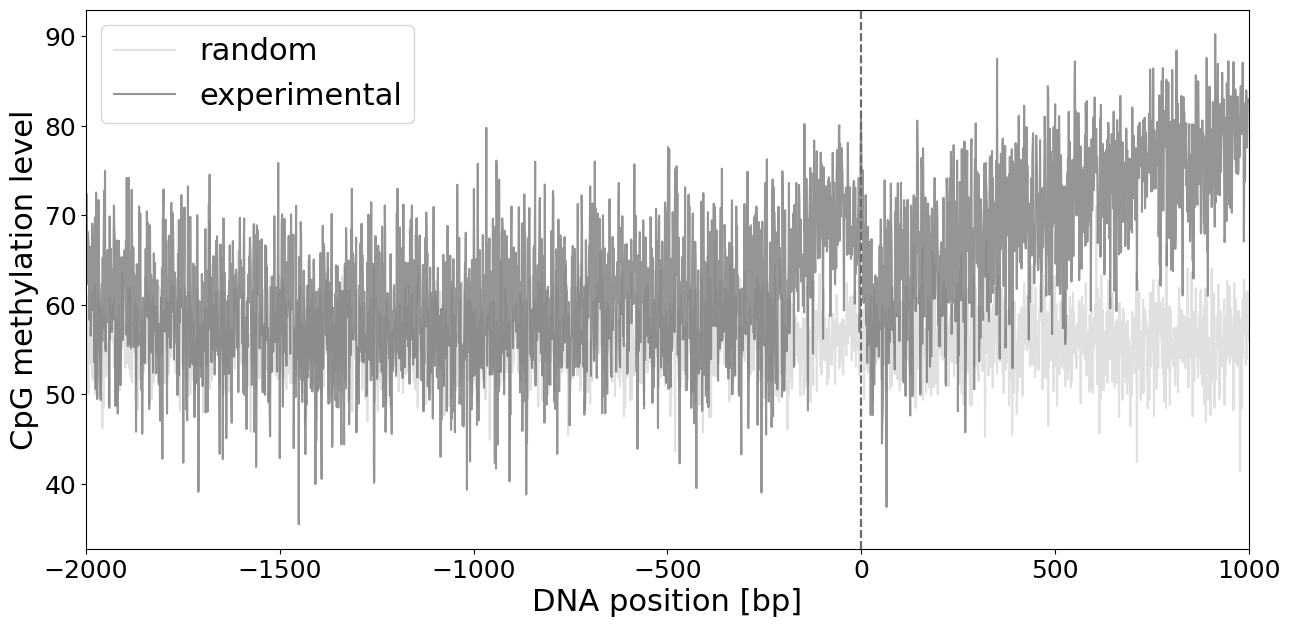

In [59]:
plot_avg_methylation_levels(df_HCG_intersect_random, 'HCG', fig=True, c='lightgray', label='random')
plot_avg_methylation_levels(df_HCG_intersect, 'HCG', fig=False, c='dimgray', label='experimental')

#### Steric Clash Plot

In [ ]:
import pickle

In [ ]:
dnmt_name = '7XIB' # 7XIB or 3PTA

In [ ]:
steric_path_1kx5 = main_path / 'superposition' / f'clash_1KX5_{dnmt_name}'
steric_path_7v9j = main_path / 'superposition' / f'clash_7V9J_{dnmt_name}'

In [ ]:
clash_dict_loc_1kx5 = steric_path_1kx5 / 'clash_dict'
info_dict_loc_1kx5 = steric_path_1kx5 / 'info_nbr_dict'

clash_dict_loc_7v9j = steric_path_7v9j / 'clash_dict'
info_dict_loc_7v9j = steric_path_7v9j / 'info_nbr_dict'

In [ ]:
with open(clash_dict_loc_1kx5, 'rb') as fin:
    clash_dict_1kx5 = pickle.load(fin)
with open(info_dict_loc_1kx5, 'rb') as fin:
    info_nbr_dict_1kx5 = pickle.load(fin)

with open(clash_dict_loc_7v9j, 'rb') as fin:
    clash_dict_7v9j = pickle.load(fin)
with open(info_dict_loc_7v9j, 'rb') as fin:
    info_nbr_dict_7v9j = pickle.load(fin)

In [ ]:
info_nbr_dict_1kx5

In [ ]:
info_nbr_dict_7v9j

In [ ]:
def get_x_y(clash_dict_, info_nbr_dict_):
    dnmt_atoms_consider_clash = info_nbr_dict_["dnmt_atoms_consider_clash"]
    print('Dnmt atoms for clash', dnmt_atoms_consider_clash)
    x = np.array(sorted(clash_dict_.keys()))
    y = []

    for pos in x:
        all_clashes = 0
        for clash_res in clash_dict_[pos]['steric_clash_list'].keys():
            atom_clashes = clash_dict_[pos]['steric_clash_list'][clash_res]
            nbr_clash_atoms = 0
            seen_atoms = set()
            for ac in atom_clashes: #['X_TYR923_N', 'A_ARG42_CD', 2.0103261]
                dnmt_atom = ac[0]
                nuc_atom = ac[1]
                if dnmt_atom not in seen_atoms:
                    seen_atoms.add(dnmt_atom)
                    nbr_clash_atoms += 1
            
            all_clashes += nbr_clash_atoms

        perc_clash_atoms = (float(all_clashes)/float(dnmt_atoms_consider_clash))*100
        y.append(perc_clash_atoms)

    y = np.array(y)

    return x, y

In [ ]:
x_1kx5, y_1kx5 = get_x_y(clash_dict_1kx5, info_nbr_dict_1kx5)
x_7v9j, y_7v9j = get_x_y(clash_dict_7v9j, info_nbr_dict_7v9j)

In [ ]:
plt.plot(x_1kx5, y_1kx5, marker='o')
plt.plot(x_7v9j, y_7v9j, marker='o')

In [ ]:
plt.plot(x_1kx5, y_1kx5, marker='o')
plt.plot(x_7v9j-126, y_7v9j, marker='o')

In [ ]:
def get_norm_accesibility(y):
    #norm clashed st acc is probability between 0 and 1
    max_clash = np.max(y)
    min_clash = np.min(y)
    print ("max_clash", max_clash)
    print ("min_clash", min_clash)
    diff = max_clash - min_clash
    y_access = []
    for y_val in y:
        norm_val = 100-(float(y_val-min_clash)/float(diff))*100 #100- because is accessibility
        y_access.append(norm_val)

    return np.array(y_access)

In [ ]:
y_access_1kx5 = get_norm_accesibility(y_1kx5)
y_access_7v9j = get_norm_accesibility(y_7v9j)

In [ ]:
plt.plot(x_1kx5, y_access_1kx5, marker='o')
plt.plot(x_7v9j-126, y_access_7v9j, marker='o')

In [ ]:
def get_x_y_dict(x, y, y_access):
    x_y_acc_dict = dict() 
    x_y_dict = dict()
    for i in range(0,len(x)):
        x_y_dict[x[i]] = y[i]
        x_y_acc_dict[x[i]] = y_access[i]
    
    return x_y_dict, x_y_acc_dict

In [ ]:
x_y_dict_1kx5, _ = get_x_y_dict(x_1kx5, y_1kx5, y_access_1kx5)
x_y_dict_7v9j, _ = get_x_y_dict(x_7v9j-126, y_7v9j, y_access_7v9j)

In [ ]:
from workspace import utils

In [ ]:
x_y_clash_dict_norm_1kx5 = utils.normalize_clash_dict(x_y_dict_1kx5)
x_y_clash_dict_norm_7v9j = utils.normalize_clash_dict(x_y_dict_7v9j)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), layout='constrained')
thresh = 10
ax[0].plot(x_y_dict_1kx5.keys(), x_y_dict_1kx5.values(), marker='o', label='true')
ax[0].plot(x_y_clash_dict_norm_1kx5.keys(), x_y_clash_dict_norm_1kx5.values(), marker='*', label='normalized')
ax[0].set_title('1kx5')
ax[0].axhline(y=thresh, ls='--', color='grey')
ax[0].plot(np.array(list(x_y_dict_1kx5.keys()))[np.array(list(x_y_dict_1kx5.values())) < thresh], 
           np.array(list(x_y_dict_1kx5.values()))[np.array(list(x_y_dict_1kx5.values())) < thresh], 'o', color='red')
ax[0].plot(np.array(list(x_y_clash_dict_norm_1kx5.keys()))[np.array(list(x_y_clash_dict_norm_1kx5.values())) < thresh], 
           np.array(list(x_y_clash_dict_norm_1kx5.values()))[np.array(list(x_y_clash_dict_norm_1kx5.values())) < thresh], '*', color='red')
ax[0].legend()
print(f'1kx5 pos under thresh true {(np.array(list(x_y_dict_1kx5.values())) < thresh).sum()}')
print(f'1kx5 pos under thresh norm {(np.array(list(x_y_clash_dict_norm_1kx5.values())) < thresh).sum()}')

ax[1].plot(x_y_dict_7v9j.keys(), x_y_dict_7v9j.values(), marker='o', label='true')
ax[1].plot(x_y_clash_dict_norm_7v9j.keys(), x_y_clash_dict_norm_7v9j.values(), marker='*', label='normalized')
ax[1].set_title('7v9j')
ax[1].axhline(y=thresh, ls='--', color='grey')
ax[1].plot(np.array(list(x_y_dict_7v9j.keys()))[np.array(list(x_y_dict_7v9j.values())) < thresh], 
           np.array(list(x_y_dict_7v9j.values()))[np.array(list(x_y_dict_7v9j.values())) < thresh], 'o', color='red')
ax[1].plot(np.array(list(x_y_clash_dict_norm_7v9j.keys()))[np.array(list(x_y_clash_dict_norm_7v9j.values())) < thresh], 
           np.array(list(x_y_clash_dict_norm_7v9j.values()))[np.array(list(x_y_clash_dict_norm_7v9j.values())) < thresh], '*', color='red')
ax[1].legend()

print(f'7v9j pos under thresh true {(np.array(list(x_y_dict_7v9j.values())) < thresh).sum()}')
print(f'7v9j pos under thresh norm {(np.array(list(x_y_clash_dict_norm_7v9j.values())) < thresh).sum()}')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), layout='constrained')
thresh = 10
ax[0].plot(x_y_dict_1kx5.keys(), x_y_dict_1kx5.values(), marker='o', label='1kx5')
ax[0].plot(x_y_dict_7v9j.keys(), x_y_dict_7v9j.values(), marker='*', label='7v9j')
ax[0].set_title('true')
ax[0].axhline(y=thresh, ls='--', color='grey')
ax[0].plot(np.array(list(x_y_dict_1kx5.keys()))[np.array(list(x_y_dict_1kx5.values())) < thresh], 
           np.array(list(x_y_dict_1kx5.values()))[np.array(list(x_y_dict_1kx5.values())) < thresh], 'o', color='red')
ax[0].plot(np.array(list(x_y_dict_7v9j.keys()))[np.array(list(x_y_dict_7v9j.values())) < thresh], 
           np.array(list(x_y_dict_7v9j.values()))[np.array(list(x_y_dict_7v9j.values())) < thresh], '*', color='red')
ax[0].legend()
print(f'1kx5 pos under thresh true {(np.array(list(x_y_dict_1kx5.values())) < thresh).sum()}')
print(f'7v9j pos under thresh true {(np.array(list(x_y_dict_7v9j.values())) < thresh).sum()}')

ax[1].plot(x_y_clash_dict_norm_1kx5.keys(), x_y_clash_dict_norm_1kx5.values(), marker='o', label='1kx5')
ax[1].plot(x_y_clash_dict_norm_7v9j.keys(), x_y_clash_dict_norm_7v9j.values(), marker='*', label='7v9j')
ax[1].set_title('norm')
ax[1].axhline(y=thresh, ls='--', color='grey')
ax[1].plot(np.array(list(x_y_clash_dict_norm_1kx5.keys()))[np.array(list(x_y_clash_dict_norm_1kx5.values())) < thresh], 
           np.array(list(x_y_clash_dict_norm_1kx5.values()))[np.array(list(x_y_clash_dict_norm_1kx5.values())) < thresh], 'o', color='red')
ax[1].plot(np.array(list(x_y_clash_dict_norm_7v9j.keys()))[np.array(list(x_y_clash_dict_norm_7v9j.values())) < thresh], 
           np.array(list(x_y_clash_dict_norm_7v9j.values()))[np.array(list(x_y_clash_dict_norm_7v9j.values())) < thresh], '*', color='red')
ax[1].legend()

print(f'1kx5 pos under thresh norm {(np.array(list(x_y_clash_dict_norm_1kx5.values())) < thresh).sum()}')
print(f'7v9j pos under thresh norm {(np.array(list(x_y_clash_dict_norm_7v9j.values())) < thresh).sum()}')

In [ ]:
# def save_dict(steric_path, x_y_dict):
#     with open(steric_path / 'x_y_dict', 'wb') as fout:
#         pickle.dump(x_y_dict, fout, -1)

In [ ]:
# save_dict(steric_path_7v9j, x_y_dict_7v9j)

In [ ]:
# save_dict(steric_path_1kx5, x_y_dict_1kx5)

In [ ]:
# with open(steric_path / 'x_y_perc_file_.txt', 'w') as fout:
#     x_y_acc_dict = dict() 
#     x_y_dict = dict()
#     for i in range(0,len(x)):
#         fout.write(str(x[i]) + "----" + str(y[i]) + "\n")
#         x_y_dict[x[i]] = y[i]
#         x_y_acc_dict[x[i]] = y_access[i]

# with open(steric_path / 'x_y_dict_', 'wb') as fout:
#     pickle.dump(x_y_dict, fout, -1)
# with open(steric_path / 'x_y_acc_dict_', 'wb') as fout:
#     pickle.dump(x_y_acc_dict, fout, -1)

In [ ]:
def plot_nbr_clashs(steric_path, clash_dict_loc, info_dict_loc, save=False):
    with open(clash_dict_loc, 'rb') as fin:
        clash_dict = pickle.load(fin)
    with open(info_dict_loc, 'rb') as fin:
        info_nbr_dict = pickle.load(fin)

    nbr_dnmt_residues = info_nbr_dict["model_dnmt_nbr_residues"]
    nbr_dnmt_atoms = info_nbr_dict["model_dnmt_nbr_atoms"]
    dnmt_atoms_consider_clash = info_nbr_dict["dnmt_atoms_consider_clash"]
    
    x = sorted(clash_dict.keys())
    #x = [12]
    y = []

    #lab_txt = []
    for pos in x:
        #nbr_clash_residues = len(clash_dict[pos]['steric_clash_list'].keys())
        #perc_clash_res = (float(nbr_clash_residues)/float(nbr_dnmt_residues))*100
        #rmsd = round(clash_dict[pos]['rmsd'],2)
        all_clashes = 0
        for clash_res in clash_dict[pos]['steric_clash_list'].keys():
            atom_clashes = clash_dict[pos]['steric_clash_list'][clash_res]
            nbr_clash_atoms = 0
            seen_atoms = set()
            for ac in atom_clashes: #['X_TYR923_N', 'A_ARG42_CD', 2.0103261]
                dnmt_atom = ac[0]
                nuc_atom = ac[1]
                if dnmt_atom not in seen_atoms:
                    seen_atoms.add(dnmt_atom)
                    nbr_clash_atoms += 1
            all_clashes += nbr_clash_atoms

        perc_clash_atoms = (float(all_clashes)/float(dnmt_atoms_consider_clash))*100
        y.append(perc_clash_atoms)
    
    #norm clashed st acc is probability between 0 and 1
    max_clash = np.max(y)
    min_clash = np.min(y)
    print ("max_clash", max_clash)
    print ("min_clash", min_clash)
    diff = max_clash - min_clash
    y_access = []
    for y_val in y:
        norm_val = 100-(float(y_val-min_clash)/float(diff))*100 #100- because is accessibility
        y_access.append(norm_val)
    
    if save:
        with open(steric_path / 'x_y_perc_file.txt', 'w') as fout:
            x_y_acc_dict = dict() 
            x_y_dict = dict()
            for i in range(0,len(x)):
                fout.write(str(x[i]) + "----" + str(y[i]) + "\n")
                x_y_dict[x[i]] = y[i]
                x_y_acc_dict[x[i]] = y_access[i]

        with open(steric_path / 'x_y_dict', 'wb') as fout:
            pickle.dump(x_y_dict, fout, -1)
        with open(steric_path / 'x_y_acc_dict', 'wb') as fout:
            pickle.dump(x_y_acc_dict, fout, -1)
    
    '''
    % ATOMS CLASHED
    '''
    fig = plt.figure(figsize=(18, 7))
    ax = plt.subplot(111)
    
    #plt.title('Superposition of DNMT1 (3PTA) and the nucleosome (1KX5)')
    # print(sum(np.array(y) < 5))
    ax.plot(x, y, linestyle="-", marker="o", linewidth=2)
    # ax.plot(np.array(x)[np.array(y) < 5], np.array(y)[np.array(y) < 5], '*', color='red')
    for pos in range(0,len(x)):
        #ax.text(x[pos]+0.3,y[pos],rmsd_list[pos])
        ax.text(x[pos]+0.2, y[pos]+0.7, x[pos], fontsize=12)
        
    plt.xlim(0,140)
    plt.xticks(range(0,len(x)+5,5), fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Nucleosome position [bp]", fontsize=18)
    plt.ylabel("DNMT1 atoms clashing [%]", fontsize=18)
    
    ax.axvline(x=74,c="grey",linewidth=2,linestyle="--")#4169e1
    
    
    '''
    ACCESSIBILITY: 100-clasehd atoms
    '''
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(111)
    plt.title('Superposition of DNMT1 (3PTA) and the nucleosome (1KX5)')
    ax.plot(x,y_access, linestyle="-" ,marker="o", linewidth=2)
    for pos in range(0,len(x)):
        ax.text(x[pos]+0.3, y_access[pos], x[pos])
        
    plt.xlim(0, 140)
    plt.xticks(range(0,len(x)+5,5), fontsize=15)
    plt.xlabel("Nucleosome position")
    plt.ylabel("Accessibility [%]")
    
    ax.axvline(x=74,c="black",linewidth=2,linestyle="-")#4169e1
    ax.axhline(y=95,c="black",linewidth=2,linestyle="--")#4169e1
    ax.text(-1,94.5,'95')

In [ ]:
clash_dict_loc = steric_path_1kx5 / 'clash_dict'
info_dict_loc = steric_path_1kx5 / 'info_nbr_dict'
plot_nbr_clashs(steric_path_1kx5, clash_dict_loc, info_dict_loc, save=False)

In [ ]:
x = list(x_y_dict_1kx5.keys())
y = list(x_y_dict_1kx5.values())

fig = plt.figure(figsize=(18, 7))
ax = plt.subplot(111)

ax.plot(x, y, linestyle="-", marker="o", linewidth=2)
for pos in range(0,len(x)):
    ax.text(x[pos]+0.2, y[pos]+0.7, x[pos], fontsize=12)
    
plt.xlim(0,140)
plt.xticks(range(0,len(x)+5,5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Nucleosome position [bp]", fontsize=18)
plt.ylabel("DNMT1 atoms clashing [%]", fontsize=18)
plt.ylim(top=100)

ax.axvline(x=74,c="grey",linewidth=2,linestyle="--")#4169e1

In [ ]:
x = list(x_y_dict_7v9j.keys())
y = list(x_y_dict_7v9j.values())

fig = plt.figure(figsize=(18, 7))
ax = plt.subplot(111)

ax.plot(x, y, linestyle="-", marker="o", linewidth=2)
for pos in range(0,len(x)):
    ax.text(x[pos]+0.2, y[pos]+0.7, x[pos], fontsize=12)
    
plt.xlim(0,140)
plt.xticks(range(0,len(x)+5,5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Nucleosome position [bp]", fontsize=18)
plt.ylabel("DNMT1 atoms clashing [%]", fontsize=18)
plt.ylim(top=100)

ax.axvline(x=74,c="grey",linewidth=2,linestyle="--")#4169e1